# Artificial Neural Networks (CS-456)
## Miniproject 1: Tic Tac Toe
- Mickaël Achkar (322190)
- Yehya El Hassan (325932)


In [23]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List, Union, Callable
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [24]:
class RlAgent():
    def __init__(self,player:str,epsilon:Union[float, Callable],learning_rate:float = 0.05,discount_factor:float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon

        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table:Dict[str,np.ndarray] = {}

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions:List[int] = [] 

        # Initialize the current reward
        self.reward = 0

        # Update current episode number
        self.current_episode = 0
        
    
    def observe_state(self, board):
        # Observe the current state of the environment
        self._update_board(board)
        self._update_list_of_possible_actions()

    def observe_reward(self,reward):
        # Observe the current reward from the environment
        self._update_reward(reward)

    def update_nb_of_episode_played(self, episode_number):
        self.current_episode = episode_number

    def get_epsilon(self):
        # Retun the current epsilob 
        if (isinstance(self.epsilon, Callable)):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def act(self, board: np.ndarray):
        # Sample from a uniform distribution
        current_state = self.get_state_key(board)

        if (random.uniform(0,1)<self.get_epsilon()):
            return self._choose_random_action()
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self,current_board_config, current_action, next_board_config, terminal_state = False):
        # update the q_table
        current_state = self.get_state_key(current_board_config)
        next_state = self.get_state_key(next_board_config)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)
        self._create_new_state_entries_if_needed(next_state)

        if not terminal_state:
            best_action = self._choose_best_action(next_state)
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward + self.discount_factor*(self.q_table[next_state][best_action]) - self.q_table[current_state][current_action])
        else:
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward - self.q_table[current_state][current_action])

    def _update_board(self,board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        available_actions = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                available_actions.append(i)
        self.list_of_possible_actions = available_actions
        return self.list_of_possible_actions

    def _update_reward(self, reward):
        # Updates the current reward
        self.reward = reward

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values_idx = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_max = np.random.choice(maximum_q_values_idx)
        return (self.list_of_possible_actions[random_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)
    
    @staticmethod
    def get_state_key(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
        return hashlib.sha1(board).hexdigest()


In [25]:

def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')
    
def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2   

def plot_rewards(number_of_episodes,rewards, ax, label = "", plot_every=250):
    episodes = np.arange(0,number_of_episodes)
    bin_means,_,_ = binned_statistic(episodes ,rewards, statistic="mean", bins =(number_of_episodes)/plot_every, range=(0,number_of_episodes))
    ax.plot(np.arange(0,number_of_episodes,plot_every),bin_means, label = label)
    ax.legend()
    return

def plot_metrics(number_of_episodes,metrics, ax, label):
    ax.plot(np.arange(0,number_of_episodes,250),metrics, label = label)
    ax.legend()
    return

Implementing a Tic Tac Toc Player using Q-learning. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table.

In [26]:
def train_rl_agent_qlearning(environment: TictactoeEnv, number_of_episodes: int, optimal_level : float, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    for episode in tqdm(range(number_of_episodes)):
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 

        # Number of RL movements 
        number_of_rl_movements = 0
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                if (number_of_rl_movements%2 ==0):
                    rl_current_state = grid
                    rl_current_action = player_rl_agent.act(grid)
                    move = (int(rl_current_action/3),rl_current_action%3)
                else:
                    rl_next_state = grid
                    rl_next_action = player_rl_agent.act(grid)
                    move = (int(rl_next_action/3),rl_next_action%3)
                    player_rl_agent.update_q_table(rl_current_state, rl_current_action, rl_next_state)

                number_of_rl_movements+=1

        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.observe_state(grid)
            player_rl_agent.observe_reward(environment.reward(rl_player_character))
            
            if end:
                rewards[episode] = (environment.reward(rl_player_character))
                #Update with the current state action as the next state as current state TODO: check
                
                player_rl_agent.update_q_table(rl_current_state, rl_current_action, grid, terminal_state=True )
        
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if (episode%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, rewards, metrics_opt, metrics_rand   




In [27]:
def compute_metrics(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, verbose: bool = False):
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_qlearning(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                rl_current_action = player_rl_agent.act(grid)
                move = (int(rl_current_action/3),rl_current_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.observe_state(grid)
            
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

Train using Q_learning and fixed epsilon.

100%|██████████| 20000/20000 [00:57<00:00, 350.55it/s]


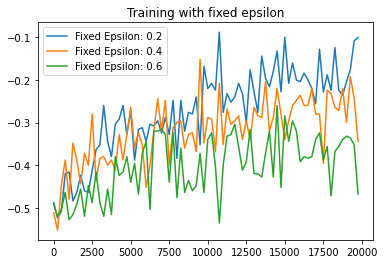

In [28]:
# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig,ax = plt.subplots()
plt.title("Training with fixed epsilon")

# Train and get the rewards for a fixed epsilon 0.2
epsilon = 0.2
player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=number_of_episodes)
plot_rewards(number_of_episodes,rewards,ax,label=f"Fixed Epsilon: {epsilon}")

# Train and get the rewards for a fixed epsilon 0.4
epsilon = 0.4
player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=number_of_episodes)
plot_rewards(number_of_episodes,rewards,ax,label=f"Fixed Epsilon: {epsilon}")

# Train and get the rewards for a fixed epsilon 0.6
epsilon = 0.6
player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=number_of_episodes)
plot_rewards(number_of_episodes,rewards,ax,label=f"Fixed Epsilon: {epsilon}")


Train using Q_learning and variable epsilon.

100%|██████████| 20000/20000 [03:56<00:00, 84.50it/s] 


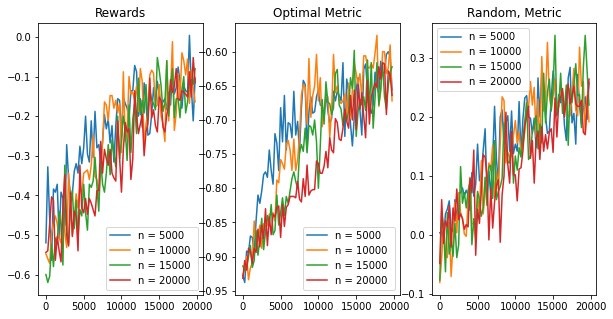

In [29]:
# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

environment = TictactoeEnv()
fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].set_title("Rewards")
axes[1].set_title("Optimal Metric")
axes[2].set_title("Random Metric")

player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"n = {number_of_exploratory_games} ")

number_of_exploratory_games = 10000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"n = {number_of_exploratory_games} ")

number_of_exploratory_games = 15000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_rand, axes[2],label = f"n = {number_of_exploratory_games} ")

number_of_exploratory_games = 20000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"n = {number_of_exploratory_games} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"n = {number_of_exploratory_games} ")


Train with various Optimal level of the Agent for the optimal $n^*$ = 5000. 

100%|██████████| 20000/20000 [03:52<00:00, 85.86it/s] 


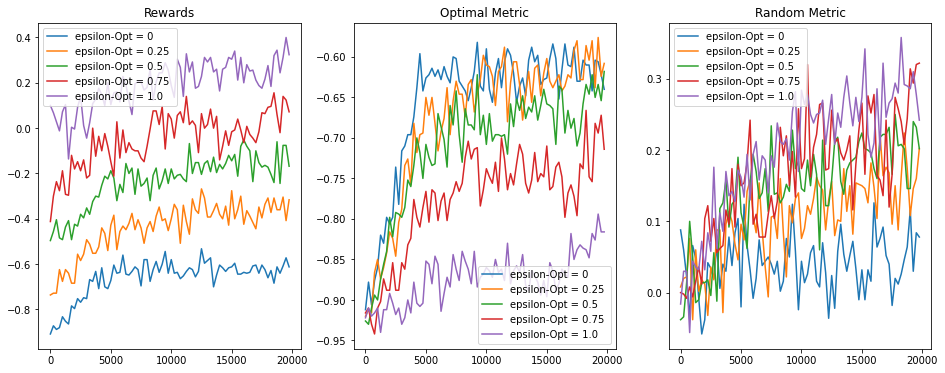

In [35]:
# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

environment = TictactoeEnv()
fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].set_title("Rewards")
axes[1].set_title("Optimal Metric")
axes[2].set_title("Random Metric")

optimal_level = 0
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label = f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"epsilon-Opt = {optimal_level} ")

optimal_level = 0.25
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"epsilon-Opt = {optimal_level} ")

optimal_level = 0.5
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label = f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_rand, axes[2],label =f"epsilon-Opt = {optimal_level} ")

optimal_level = 0.75
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"epsilon-Opt = {optimal_level} ")

optimal_level = 1.0
player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
plot_rewards(number_of_episodes,rewards, axes[0], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_opt, axes[1], label =f"epsilon-Opt = {optimal_level} ")
plot_metrics(number_of_episodes,m_rand, axes[2], label = f"epsilon-Opt = {optimal_level} ")
